In [ ]:
pip install pyDOE

  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp37-none-any.whl size=18184 sha256=199391f4948378b5e3d9933a736d7af29d875bec00c526be958672810970a0b3
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pyDOE


In [ ]:
%matplotlib inline

In [ ]:
# imports

import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt 
# Edit the font, font size, and axes width
mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 24
plt.rcParams['axes.linewidth'] = 2
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
#plt.style.use('seaborn-bright')
import torch
import torch.nn as nn
from pyDOE import *
from scipy.integrate import odeint
import time
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
torch.__version__

cuda


'1.8.1+cu101'

In [ ]:
torch.manual_seed(31)
np.random.seed(31)

In [ ]:
class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP,self).__init__()
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.iter = 0
        
        
    
        'Xavier Normal Initialization'
        
        for i in range(len(layers)-1):
            
            # weights from a normal distribution 
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
       
        
        for i in range(len(layers)-2):
            
            z = self.linears[i](x)
                        
            x = self.activation(z)
            
        x = self.linears[-1](x)
        return x

    
    def loss_bc_init(self,x,y):
      loss_u = self.loss_function(self.forward(x), y)
      return loss_u

    def loss_initernal(self, x_train):
      x_train.requires_grad = True
      p = self.forward(x_train)
      u_g = gradients(p, x_train)[0]
      u_x, u_t= u_g[:, 0], u_g[:, [1]]
      u_xx = gradients(u_x, x_train)[0][:, [0]]
      pde = u_t - D*u_xx
      loss_pde = pde.pow(2).mean()
      return loss_pde

    def loss(self,x,y,x_to_train_f):

        loss_u = self.loss_bc_init(init_cond_train,u_init_cond_train)
        loss_f = self.loss_initernal(f_train)
        
        loss_val = loss_u + loss_f
        
        return loss_val

    def closure(self):
        
        optimizer.zero_grad()
        
        loss = self.loss(init_cond_train, u_init_cond_train, f_train)
        
        
        loss.backward()
                
        self.iter += 1
        
        return loss    
          
      

In [ ]:
def gradients(outputs, inputs):
     return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

def nptoTensor(data):
     return torch.from_numpy(data).to(device).float()


In [ ]:
def trainingdata(Nx,Nt,Nf,Nu):
    x = np.linspace(0,1,Nx)
    t = np.linspace(0,1,Nt)
    X, T = np.meshgrid(x,t)

    intial_condition = np.hstack((X[0,:][:,None], T[0,:][:,None]))
    u_inital = np.sin(np.pi*x).reshape(-1,1)

    left_bc = np.hstack((X[:,0][:,None], T[:,0][:,None]))
    u_left_bc =  np.zeros(len(t)).reshape(-1,1)

    right_bc = np.hstack((X[:,-1][:,None], T[:,0][:,None]))
    u_right_bc =  np.zeros(len(t)).reshape(-1,1)

    all_Init_bcs = np.vstack([intial_condition, left_bc, right_bc])
    all_u_init_bcs = np.vstack([u_inital, u_left_bc, u_right_bc])

    idx = np.random.choice(all_Init_bcs.shape[0],Nu, replace=False)

    all_Init_bcs = all_Init_bcs[idx,:]
    all_u_init_bcs = all_u_init_bcs[idx,:]

    f_train = lhs(2,Nf)
    f_train = np.vstack((f_train, all_Init_bcs))

    return all_Init_bcs , all_u_init_bcs , f_train

In [ ]:
N_u = 300 # Random point
N_x = 100 #Total number of data points for 'x'
N_t = 100 #Total number of data points for 't'
N_f = 10000 #Total number of collocation points 
init_cond_train_np_array, u_init_cond_train_np_array, f_train_np_array = trainingdata(N_x,N_t,N_f, N_u)



In [ ]:
init_cond_train = nptoTensor(init_cond_train_np_array)
u_init_cond_train = nptoTensor(u_init_cond_train_np_array)
f_train = nptoTensor(f_train_np_array)
D = .1
layers = np.array([2,32,32,32,32,32,32,32,32,32,32,1])
mlp = MLP(layers).to(device)

In [ ]:
step_size = 20000
gamma = 0.5
A_hist = []
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0001,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
max_iter = 10000

tic = time.time()

for i in range(max_iter):

     loss = mlp.loss(init_cond_train, u_init_cond_train, f_train)
     A_hist.append([i,loss]) 
     loss.backward() #backprop
     optimizer.step()
     optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
     
     if (i+1) % 10000 == 0:
          print("Epoch: {}, MSE: {:.6f}".format((i+1), loss))

toc = time.time()
print(f'total training time in minutes: {(toc-tic)/60}')


In [ ]:
#Save the model
path = '1-Diffusion_PDE.pth'
torch.save(mlp.state_dict(), path)

In [ ]:
#Load the model
path = '/content/1-Diffusion_PDE (2).pth'
mlp.load_state_dict(torch.load(path))
mlp.eval()

MLP(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Linear(in_features=32, out_features=32, bias=True)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Linear(in_features=32, out_features=32, bias=True)
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): Linear(in_features=32, out_features=32, bias=True)
    (10): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
#Save the model for C++ Environment

# Load a sample image
model = MLP(layers)
state_dict = torch.load('/content/1-Diffusion_PDE (2).pth')
model.load_state_dict(state_dict)
model.eval()
example = torch.rand(1,2)

# run the tracing
traced_script_module = torch.jit.trace(model, example)
# save the converted model
#traced_script_module.save("Diffusion_PDE.pt")
torch.jit.save(traced_script_module,"Diffusion_PDE.pt")
loaded = torch.jit.load("Diffusion_PDE.pt")



In [ ]:
A_hist = np.array(A_hist)
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0, 0, 1, 1])
# Show the major grid lines with dark grey lines
ax.grid(b=True, which='major', color='#666666', linestyle='-')
# Show the minor grid lines with very faint and almost transparent grey lines
ax.minorticks_on()
ax.grid(b=True, which='minor', color='#555555', linestyle='-', alpha=0.1)
ax.plot(A_hist[:,0], A_hist[:,1],linewidth=2, label='Learning')
ax.legend( loc='best', frameon=True, fontsize=22)

ax.semilogy()
ax.set_xlabel('Epochs', labelpad=10)
ax.set_ylabel('Training Loss', labelpad=10)
plt.savefig('Activation.png', dpi=300, transparent=False, bbox_inches='tight')


In [ ]:
def central_difference():
    return u[n][i] + delta_t*(alpha * (u[n][i+1] - 2*u[n][i] + u[n][i-1])/(delta_x)**2)

alpha = .1
points_in_x = 20

x =np.linspace(0,1,points_in_x)
delta_x = x[1] - x[0]

delta_t = 0.5*delta_x**2/alpha
#delta_t = .002
points_in_t = 1./delta_t

# y = np.linspace(0,1,11)
# delta_x = y[1] - y[0]

t = np.linspace(0,1,int(points_in_t))
delta_t = t[1] - t[0]

u = np.zeros((len(t),len(x)))

u[: , 0] = 0                         # left boundary
u[: , len(x)-1] = 0                  # right boundary

#u[ 0 , 1:len(x)-1 ] = (1 - x[1:len(x)-1])*x[1:len(x)-1]*4              # initial condition
u[ 0 , 1:len(x)-1 ] = np.sin(np.pi*x[1:len(x)-1])          # initial condition
#u[ 0 , int(len(x)/2) ] = 1                              # point source initial condition
#u[ 0 , :len(x)-1 ] = 0          # initial condition


for n in range(0 , len(t)-1):
    for i in range(1 , len(x)-1):
        u[n+1][i] = central_difference()



findfont: Font family ['Avenir'] not found. Falling back to DejaVu Sans.


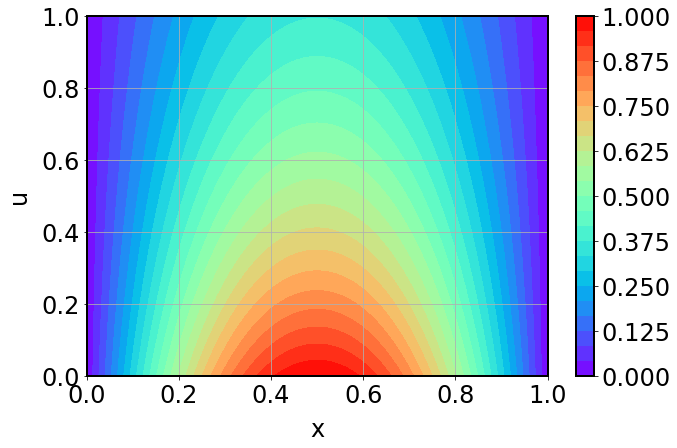

In [ ]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0, 0, 1, 1])
img = ax.contourf(x,t,u,levels=np.linspace(0, 1, 25),cmap = 'rainbow')
fig.colorbar(img)
ax.grid()
ax.set_xlabel('x', labelpad=10)
ax.set_ylabel('u', labelpad=10)
plt.savefig('1DFDM.png', dpi=300, transparent=False, bbox_inches='tight')

In [ ]:
def build_mesh(N, t):
    x = np.linspace(0,1,N)
    _t = np.array([t])
    m = np.meshgrid(x, _t)
    m = np.stack(m, -1).reshape(-1, 2)
    return x, t, m

x1, t1, m1 = build_mesh(20, 0)
x2, t2, m2 = build_mesh(20, .25)
x3, t3, m3 = build_mesh(20, .5)
x4, t4, m4 = build_mesh(20, .75)
x5, t5, m5 = build_mesh(20, 1)


In [ ]:
def eval_model(m):
    mlp.eval()
    with torch.no_grad():
        p = mlp(torch.tensor(m).float().to(device)).cpu().numpy()
    return p

p1 = eval_model(m1)
p2 = eval_model(m2)
p3 = eval_model(m3)
p4 = eval_model(m4)
p5= eval_model(m5)


In [ ]:
def plot_model(x, p, t,u_fdm):
    pe = np.sin(np.pi*x)*np.exp((-.1*t)*(np.pi**2))
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xlim([-0.03, 1.03])
    ax.set_ylim([-0.03, 1.03])
    ax.plot(x, pe,color = 'k',linestyle = '-',linewidth=6, label="Exact")
    ax.plot(x, p, ms=25, marker='X', color = 'r',linestyle = 'None',label="NN solution")
    ax.plot(x, u_fdm, ms=12, marker='s', color = 'g',linestyle = 'None',label="FDM solution")
    ax.set_xlabel('x', labelpad=10)
    ax.set_ylabel('u(x,t)', labelpad=10)
    # Show the major grid lines with dark grey lines
    ax.grid(b=True, which='major', color='#666666', linestyle='-')
    # Show the minor grid lines with very faint and almost transparent grey lines
    ax.minorticks_on()
    ax.grid(b=True, which='minor', color='#555555', linestyle='-', alpha=0.1)
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
         # frameon=False, shadow=False, ncol=3, fontsize=22)
    ax.legend( loc='best', frameon=False, facecolor='#9BC7C8', framealpha=2,fontsize=22)
    l2 = np.sqrt(np.sum((pe-p.T)**2))/(np.sqrt(np.sum(pe)**2))
    l2_fdm = np.sqrt(np.sum((pe-u_fdm)**2))/(np.sqrt(np.sum(pe)**2))
    
    #plt.title(f"t = {t:.3f} (L2_NN = {l2:.7f}) (L2_FDM = {l2_fdm:.7f})")
    plt.savefig(f"t = {t:.3f}.png", dpi=600, transparent=False, bbox_inches='tight')
    plt.show()
    


In [ ]:
plot_model(x1, p1, t1,u[0,:])
plot_model(x2, p2, t2, u[17,:])
plot_model(x3, p3, t3, u[35,:])
plot_model(x4, p4, t4, u[53,:])
plot_model(x5, p5, t5, u[-1,:])